
**Data source :** [Mobile price Dataset]( https://www.kaggle.com/iabhishekofficial/mobile-price-classification)



# Loading Laibrary

In [ ]:
%%capture
!pip install category-encoders

# Standard Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce

# Classifiers to Use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Other needed imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/helah20/Dataset/main/train.csv')
dft=pd.read_csv('https://raw.githubusercontent.com/helah20/Dataset/main/test.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


# Scalling Data 

In [ ]:
# Scale continuous features and replace in the original df
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df))


#  Modeling  :

In [ ]:
# Create a dictionary holding all Classifiers and preprocessing techniques
models = {
    "lr": make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),LogisticRegression()),
    "knn": make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),KNeighborsClassifier()),
    "dt": make_pipeline(ce.OneHotEncoder(),SimpleImputer(strategy="median") ,DecisionTreeClassifier())
}

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=9000)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# Split data
X = df.drop("price_range", axis=1)
y = df["price_range"]

# Baseline Score
print("Model Baseline")
df["price_range"].value_counts(normalize=True)[0]

Model Baseline


0.25

In [ ]:
# Evaluate models on their own

result_ls = []
model_ls = []


# Iterate over models dict and evaluate each seprately
for key, value in models.items():

    # gather scores KFold cross validation scores
    score = evaluate_model(value, X, y)
    result_ls.append(score) # save results
    model_ls.append(key) # save model name
    print(f"Model: {key}, Score: {np.mean(score)}")

Model: lr, Score: 0.63175
Model: knn, Score: 0.92275
Model: dt, Score: 0.82975


#### Looking at our crossval score boxplots we can see that **KNN** models are performing pretty much **HIGHER**  than others.

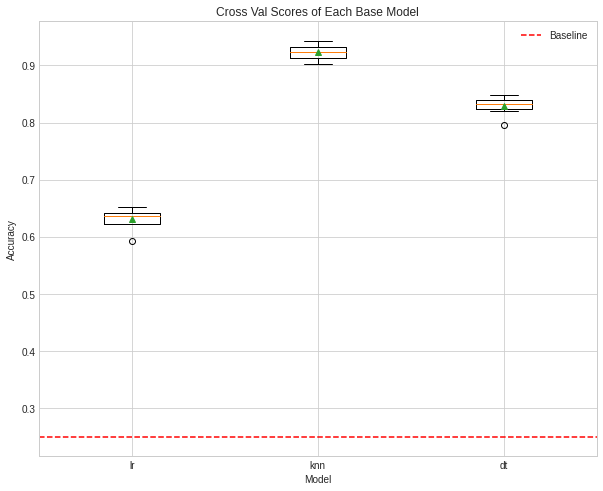

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(10,8))
plt.boxplot(result_ls, labels=model_ls, showmeans=True)
plt.title("Cross Val Scores of Each Base Model")
plt.xlabel("Model")
plt.axhline(0.25, linestyle="--", c="r", label="Baseline")
plt.legend()
plt.ylabel("Accuracy");

 let's see if we can do better with [ model stacking ](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [ ]:
# Stacking Classifier is expecting a list
stack_ls = [
            ("lr", make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),LogisticRegression())),
            ("knn", make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),KNeighborsClassifier())),
            ("dt", make_pipeline(ce.OneHotEncoder(),SimpleImputer(strategy="median") ,DecisionTreeClassifier()))
            ]

# Create Stacked Classifier
stack_model = StackingClassifier(stack_ls, cv=5)

# Add stack_model to models dictionary
models["stacked"] = stack_model

In [ ]:
# Evaluate All Models
result_ls = []
model_ls = []

# Iterate over models dict and evaluate each seprately
for key, value in models.items():

    # gather scores KFold cross validation scores
    score = evaluate_model(value, X, y)
    result_ls.append(score) # save results
    model_ls.append(key) # save model name
    print(f"Model: {key}, Score: {np.mean(score)}")

Model: lr, Score: 0.63175
Model: knn, Score: 0.92275
Model: dt, Score: 0.8237500000000001
Model: stacked, Score: 0.9225


#### as we can see here our stacked estimator performed better than all base estimators so we will use the stacked estimator. 

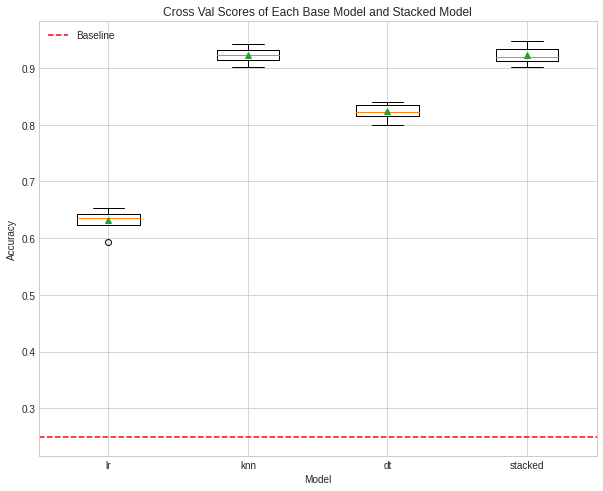

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(10,8))
plt.boxplot(result_ls, labels=model_ls, showmeans=True)
plt.title("Cross Val Scores of Each Base Model and Stacked Model")
plt.xlabel("Model")
plt.axhline(0.25, linestyle="--", c="r", label="Baseline")
plt.legend()
plt.ylabel("Accuracy");

#### Now let's find the best pram using [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and fit our model

Grid Search

In [ ]:
param_grid = {
    "dt__onehotencoder__drop_invariant": [True, False],
    "dt__simpleimputer__strategy": ["mean", "median"],
    "dt__decisiontreeclassifier__criterion": ["gini", "entropy"],
    "dt__decisiontreeclassifier__splitter": ["best", "random"],
    "dt__decisiontreeclassifier__max_depth": [None, 2],
    "dt__decisiontreeclassifier__ccp_alpha": [0.0,0.030],
    "lr__onehotencoder__drop_invariant": [True, False],
    "lr__simpleimputer__strategy": ["mean", "median"],
    "lr__logisticregression__solver": ["lbfgs", "liblinear"],
    "knn__onehotencoder__drop_invariant": [True, False],
    "knn__kneighborsclassifier__n_neighbors": [5,10],
    "knn__kneighborsclassifier__metric": ["minkowski", "euclidean"],
}

grid_model = GridSearchCV(stack_model, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)

grid_model.fit(X,y)

Fitting 5 folds for each of 4096 candidates, totalling 20480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 65.5min
[Parallel(n_jobs=-1)]: Done 6841 tasks      | elapsed: 77.3min
[Parallel(n_jobs=-1)]: Done 7934 tasks      | elapsed: 89.4min
[Parallel(n_jobs=-1)]: Done 9109 tasks      | 

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('lr',
                                                       Pipeline(memory=None,
                                                                steps=[('onehotencoder',
                                                                        OneHotEncoder(cols=None,
                                                                                      drop_invariant=False,
                                                                                      handle_missing='value',
                                                                                      handle_unknown='value',
                                                                                      return_df=True,
                                                                                      use_cat_names=False,
                                                       

In [ ]:
grid_model.best_score_

0.945

In [ ]:
grid_model.best_params_

{'dt__decisiontreeclassifier__ccp_alpha': 0.0,
 'dt__decisiontreeclassifier__criterion': 'gini',
 'dt__decisiontreeclassifier__max_depth': None,
 'dt__decisiontreeclassifier__splitter': 'random',
 'dt__onehotencoder__drop_invariant': False,
 'dt__simpleimputer__strategy': 'median',
 'knn__kneighborsclassifier__metric': 'euclidean',
 'knn__kneighborsclassifier__n_neighbors': 10,
 'knn__onehotencoder__drop_invariant': True,
 'lr__logisticregression__solver': 'liblinear',
 'lr__onehotencoder__drop_invariant': True,
 'lr__simpleimputer__strategy': 'mean'}

In [ ]:
# Pull out best model CV results to plot alongside all models tested
grid_df = pd.DataFrame(grid_model.cv_results_)
grid_cv_score_best = grid_df[grid_df["rank_test_score"]==1].loc[:,"split0_test_score":"split4_test_score"].T[500].values

In [ ]:
grid_cv_score_best 

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
500,0.9525,0.94,0.96,0.9375,0.935


In [ ]:
# Add results to running list of other model scores
result_ls.append(grid_cv_score_best)
model_ls.append("grid")

<Figure size 432x288 with 0 Axes>

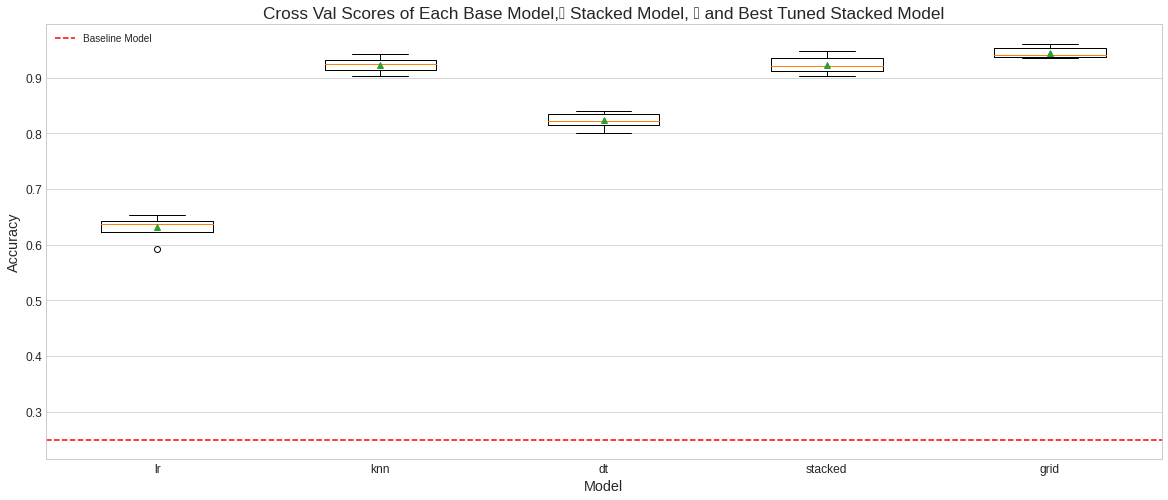

In [ ]:
# plot results
plt.style.use("seaborn-whitegrid")
plt.tight_layout()
plt.figure(figsize=(20,8))
plt.boxplot(result_ls, labels=model_ls, showmeans=True)
plt.title("Cross Val Scores of Each Base Model, Stacked Model,  and Best Tuned Stacked Model", fontsize="xx-large")
plt.xlabel("Model", fontsize="x-large")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.axhline(0.25, linestyle="--", c="r", label="Baseline Model")
plt.legend()
plt.ylabel("Accuracy", fontsize="x-large")
plt.grid(b=None, axis="x")
plt.savefig("compare_model.png", dpi=150);